In [1]:
# Importing Libraries
import tables
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('/Users/eframe/dmi/src')
import compton 
import matplotlib.ticker as ticker
import pandas as pd
from scipy.optimize import curve_fit
from scipy.special import xlogy, erf
import math as m

In [13]:
# Inputs for Compton image reconstruction
E, sigma = 440, 2
mu_low, mu_high = -0.4, 1
lever_thres = 14
poses = np.array( [ 0, 315, 270, 225, 180, 135, 90, 45 ] ) * np.pi / 180
inputs = np.array( ['/Users/eframe/Downloads/mouse10.6.21/mouse0deg_COMP.h5',
                   '/Users/eframe/Downloads/mouse10.6.21/mouse45deg_COMP.h5',
                   '/Users/eframe/Downloads/mouse10.6.21/mouse90deg_COMP.h5',
                   '/Users/eframe/Downloads/mouse10.6.21/mouse135deg_COMP.h5',
                   '/Users/eframe/Downloads/mouse10.6.21/mouse180deg_COMP.h5',
                   '/Users/eframe/Downloads/mouse10.6.21/mouse225deg_COMP.h5',
                   '/Users/eframe/Downloads/mouse10.6.21/mouse270deg_COMP.h5',
                   '/Users/eframe/Downloads/mouse10.6.21/mouse315deg_COMP.h5'] ) 

poses = np.array( [ 0 ] ) * np.pi / 180
inputs = np.array( ['/Users/eframe/Downloads/mouse0deg_COMP.h5'] ) 

binsize = 2
sourceX, sourceY, sourceZ = np.mgrid[ -20:22:binsize, -35:37:binsize, -20:22:binsize ]
sourcePixels = np.array( [ sourceX.flatten(), sourceY.flatten(), sourceZ.flatten() ] ).T

In [14]:
# Getting Compton cones from detector data for each pose
interPos, interPos2, coneDir, coneMu = [], [], [], []
for i in np.arange( len( inputs ) ):
    f = tables.open_file( inputs[ i ], 'r' )
    time = f.root.EventData.read()['timestamp']
    duration = ( time[-1] * 10 ** -8 - time[0] * 10 ** -8 ) / 60
    print('minutes:', duration)
    d = f.root.Interactions.Double.read()
    d['x'] = d['x'] - 38 
    d['y'] = d['y'] - 38  
    l22 = d.reshape( int ( len ( d ) / 2 ), 2 ) 

    # Getting Cone Data
    emask = ( l22['energy'].sum( axis = 1 ) >= E - sigma ) & ( l22['energy'].sum( axis = 1 ) <= E + sigma )   
    events_old = l22[emask]
    events = compton.correct_depth( events_old )
    events['z'] = -events['z']
    
    iP, iP2, cD, cM = compton.convertToConeData( events, E, lever_thres )
    
#     # Sequencing Interactions
#     energy1 = np.array( [ events['energy' ][ :, 0 ], events['energy'][ :, 1 ] ] ).T
#     energy2 = np.array( [ events['energy' ][ :, 1 ], events['energy'][ :, 0 ] ] ).T
#     p1 = np.squeeze( np.array( [ events['x'][ :, 0 ], events['y'][ :, 0 ], events['z'][ :, 0 ] ] ) ).T
#     p2 = np.squeeze( np.array( [ events['x'][ :, 1 ], events['y'][ :, 1 ], events['z'][ :, 1 ] ] ) ).T
#     pos1 = np.concatenate( ( [ p1, p2 ] ) , axis = 1 ).reshape( len( p1 ), 2, 3 )
#     pos2 = np.concatenate( ( [ p2, p1 ] ) , axis = 1 ).reshape( len( p1 ), 2, 3 )

#     P12, P21 = compton.sequence_probability( energy1, pos1, E )
#     mask = ( P12 < P21 )
#     energy = energy1.copy()
#     energy[mask] = energy2[mask]
#     pos = pos1.copy()
#     pos[mask] = pos2[mask]
#     iP, iP2, cD, cM = compton.convertToConeData_SEQ( energy, pos, E, lever_thres )
    
    mask = ( cM > mu_low ) & ( cM < mu_high )
    interPos.append( iP[mask] )
    interPos2.append( iP2[mask] )
    coneMu.append( cM[mask] )
    coneDir.append( cD[mask] )

minutes: 75.01009653983333


0.0


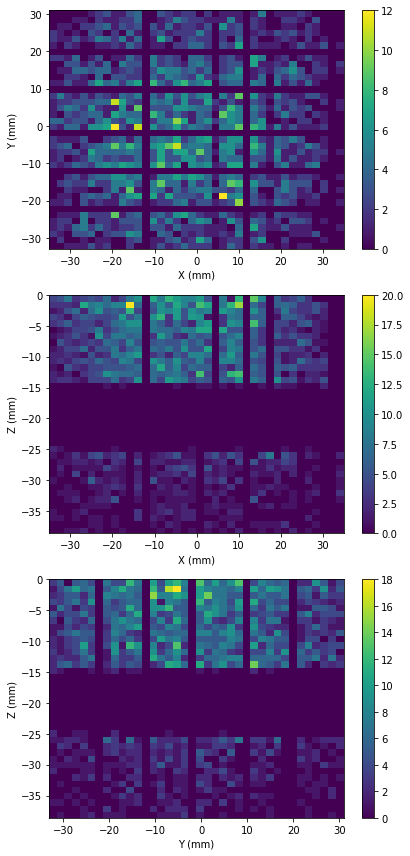

In [15]:
# Heatmap of interaction locations
get_ipython().run_line_magic('matplotlib', 'inline')
for i in np.arange( len( interPos ) ):
    print( poses[i] )
    pos = interPos[i]
    plt.figure( figsize=( 6,12 ) )
    # XY
    plt.subplot( 311 )
    plt.hist2d( pos[ :, 0 ], pos[ :, 1 ], bins = ( 38, 38 ) )
    plt.colorbar()
    plt.xlabel( "X (mm)" )
    plt.ylabel( "Y (mm)" )
    # XZ
    plt.subplot( 312 )
    plt.hist2d(pos[ :, 0 ], pos[ :, 2 ], bins = ( 38, 38 ) )
    plt.colorbar()
    plt.xlabel( "X (mm)" )
    plt.ylabel( "Z (mm)" )
    # YZ
    plt.subplot( 313 )
    plt.hist2d(pos[ :, 1 ], pos[ :, 2 ], bins = ( 38, 38 ) )
    plt.colorbar()
    plt.xlabel( "Y (mm)" )
    plt.ylabel( "Z (mm)" )
    # Render
    plt.tight_layout()
    plt.show()

In [16]:
# Defining new source image space for each pose
center = np.array( [ 0, 0, 38] )
sourcePixelsNew = []
for i in np.arange( len( poses ) ):
    ang = poses[ i ]
    R = np.array( [  [ np.cos( ang ), 0, np.sin( ang ) ], [ 0, 1, 0 ], [ -np.sin( ang ), 0, np.cos( ang ) ] ] ).T
    B = np.array( [ [ 1, 0, 0 ], [ 0, 1, 0 ], [ 0, 0, 1 ] ] )
    K = np.array( np.dot( R, B ) )
    sourcePixelsNew.append(  np.dot( sourcePixels, R ) + center ) 

/Users/eframe/dmi/src/compton.py:139: RuntimeWarning: invalid value encountered in sqrt
  sin_nu = np.sqrt(1 - nu**2)


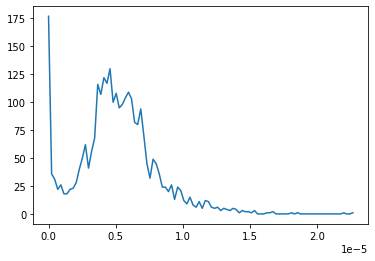

In [17]:
# Getting Backprojected Data
get_ipython().run_line_magic('matplotlib', 'inline')
backproj, backproj_inner, backproj_outer = [], [], []
for i in np.arange( len(interPos) ):
    bp = compton.coneVoxel2( sourcePixelsNew[i], interPos[i], coneDir[i], coneMu[i], 0.05, binsize  )
    
    xcoord = sourcePixels[:,0] 
    ycoord = sourcePixels[:,1]
    zcoord = sourcePixels[:,2]
    
    bp_outer = bp.copy()
    bp_inner = bp.copy()
    
    mask_outer = ( np.sqrt( zcoord ** 2 + xcoord ** 2  ) > 20 ) 
    mask_inner = ( np.sqrt( zcoord ** 2 + xcoord ** 2  ) > 18 ) 
    
    bp_outer.T[mask_outer] = 0
    bp_inner.T[mask_inner] = 0
    
    v = ( bp ).sum( 1 )

    
    mask2 = np.isnan( v ) | ( v < 1e-20 )
    backproj.append( bp[~mask2] )
    backproj_inner.append( bp_inner[~mask2] )
    backproj_outer.append( bp_outer[~mask2] )
    
    hist, bins = np.histogram( v[~mask2], bins = 100 )
    plt.plot( bins[ :-1 ], hist )
    plt.show()

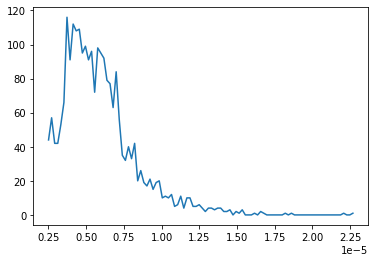

In [18]:
%matplotlib inline
backproj_New = []
for i in np.arange( len(interPos) ):
    bp = np.copy( np.array( backproj[i] ) ) 
    bp_inner = np.copy( np.array( backproj_inner[i] ) )
    bp_outer = np.copy( np.array( backproj_outer[i] ) )
    v = bp.sum(1)
    mask = (v > 2.5e-6)
    backproj_New.append( bp[mask] )
    hist, bins = np.histogram( bp[mask].sum(1), bins = 100 )
    plt.plot( bins[ :-1 ], hist)
    plt.show()

In [19]:
# Calculating Sensitivity Map 1
sensMap = []
eps = 1e-10
det = 37

for i in np.arange( len( poses ) ):
    x = np.round( sourcePixelsNew[i][:,0]  ).astype(int)
    y = np.round( sourcePixelsNew[i][:,1] ).astype(int)
    z = np.round( sourcePixelsNew[i][:,2] ).astype(int)
    R = np.sqrt( x ** 2 + y ** 2 + z ** 2)
    c1 = x + det
    c2 = x - det
    d1 = y + det
    d2 = y - det
    a1 = c1 / ( np.sqrt( c1 ** 2 + z ** 2 ) + eps )
    b1 = d1 / ( np.sqrt( d1 ** 2 + z ** 2 ) + eps )
    a2 = c2 / ( np.sqrt( c2 ** 2 + z ** 2 ) + eps )
    b2 = d2 / ( np.sqrt( d2 ** 2 + z ** 2 ) + eps )
    firstsum = np.arcsin( a1 * b1 ) * ( ( -1 ) ** 2 ) + np.arcsin( a1 * b2 ) * ( ( -1 ) ** 3 )
    secondsum = np.arcsin( a2 * b1 ) * ( ( -1 ) ** 3 ) + np.arcsin( a2 * b2 ) * ( ( -1 ) ** 4 )
    sens =  ( firstsum + secondsum ) / ( 4 * np.pi ) 
    sensMap.append( sens )
sens1 = np.array( sensMap ).sum(0)

0


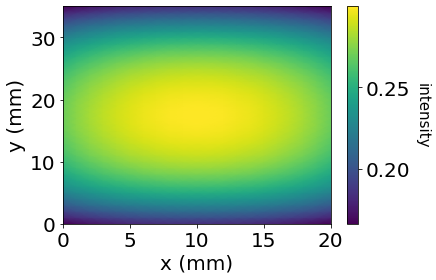

1


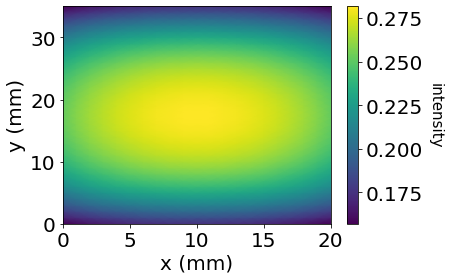

2


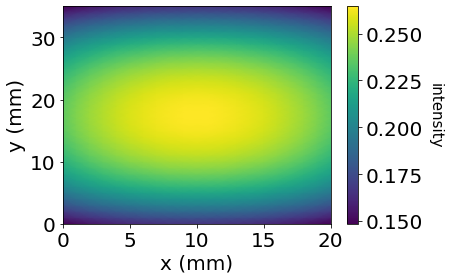

3


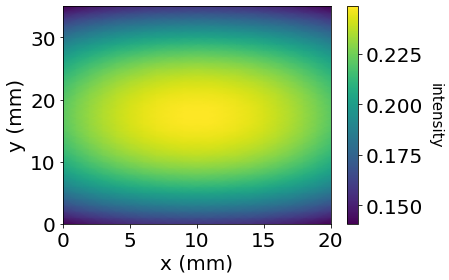

4


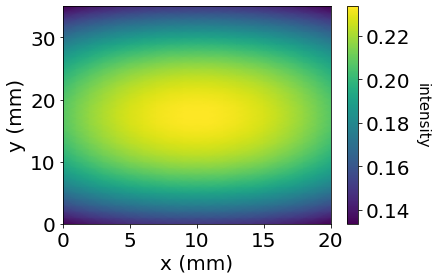

5


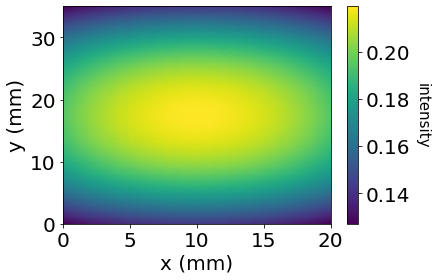

6


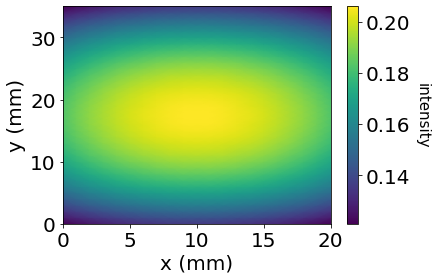

7


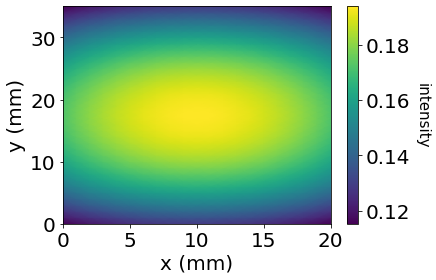

8


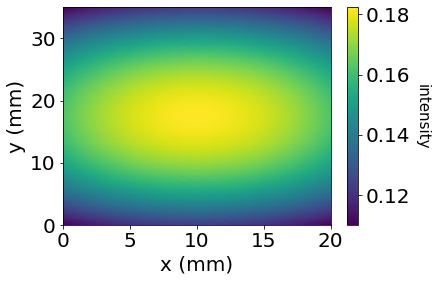

9


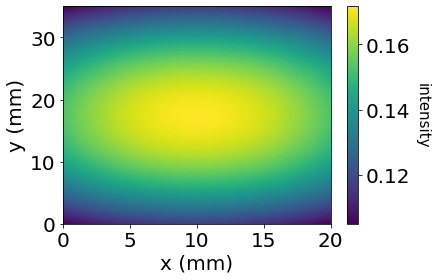

10


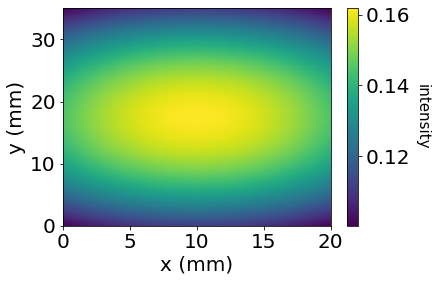

11


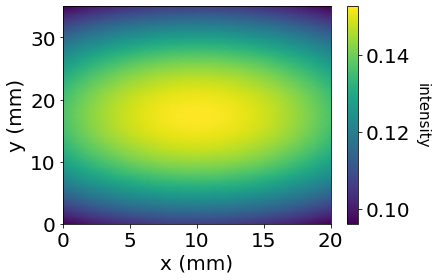

12


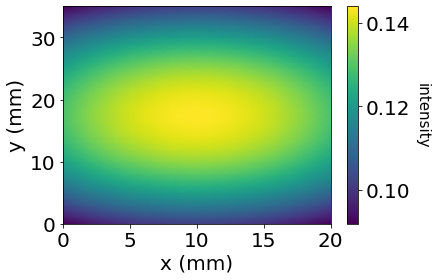

13


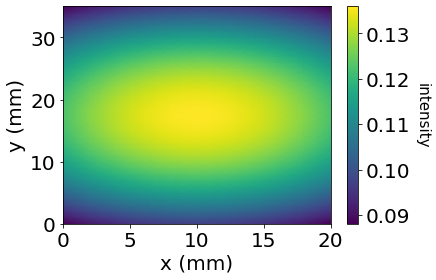

14


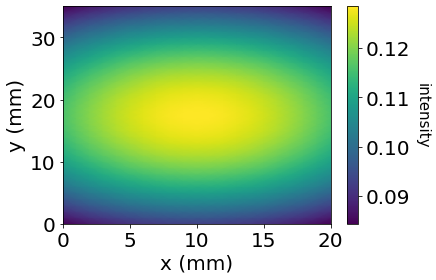

15


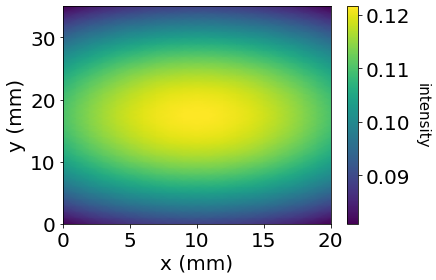

16


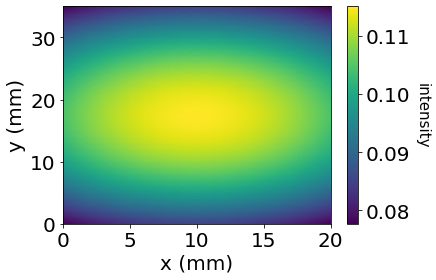

17


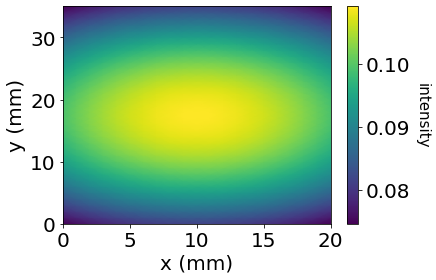

18


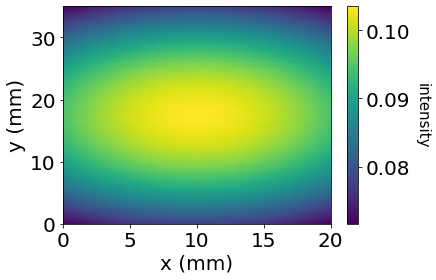

19


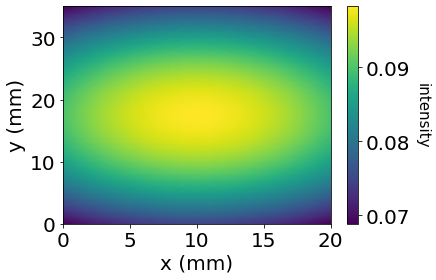

20


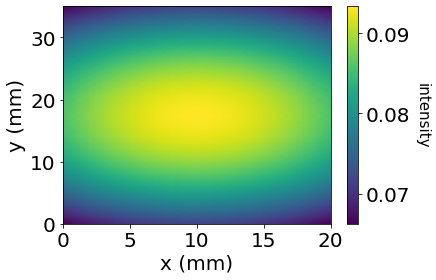

In [20]:
%matplotlib inline
sens_grid = sens1.reshape( sourceX.shape )
a, b = min(sens_grid.flatten()), max(sens_grid.flatten())
for i in np.arange( sourceX.shape[0] ):
    print(i)
    fig, ax = plt.subplots()
    grid = sens_grid[ :, :, i] 
    im = ax.pcolormesh( grid.T,  shading = 'gouraud' ) 
    ax.set_xlabel( 'x (mm)', fontsize = 20 )
    ax.set_ylabel( 'y (mm)', fontsize = 20 )
    ax.tick_params( labelsize = 20 )
    cbar = plt.colorbar( im )
    cbar.set_label( label = 'intensity', rotation = 270, fontsize = 15, labelpad = 20 )
    cbar.ax.tick_params( labelsize = 20 )
    plt.show()

In [ ]:
det_data = backproj_New.copy()
nIter = 1000
eta = 2e-4
eps = 0.1
sensitivity = sens1.copy()
maxsens = sensitivity.max()

lamb = np.ones( len( sourcePixels ) )
for n in np.arange( nIter ):
    print( 'iteration: %i of %i' %( n + 1, nIter ) )
    outerSum = np.zeros( ( len( sourcePixels )  ), dtype = 'float32' )
    ratio = np.zeros( len( sourcePixels ) )
    lamb3D = np.pad( lamb.copy().reshape( sourceX.shape ), 1 )
    P_alpha = np.zeros_like( lamb3D )
    for i in np.arange( 1, lamb3D.shape[0] - 1 ):
        for j in np.arange( 1, lamb3D.shape[1] - 1 ):
            for k in np.arange( 1, lamb3D.shape[2] - 1 ):
                val = -eta * maxsens * \
                                    ( np.sign( lamb3D[i][j][k] - lamb3D[i-1][j][k] ) + \
                                    np.sign( lamb3D[i][j][k] - lamb3D[i+1][j][k] ) + \
                                    np.sign( lamb3D[i][j][k] - lamb3D[i][j-1][k] ) + \
                                    np.sign( lamb3D[i][j][k] - lamb3D[i][j+1][k] ) + \
                                    np.sign( lamb3D[i][j][k] - lamb3D[i-1][j-1][k] ) + \
                                    np.sign( lamb3D[i][j][k] - lamb3D[i-1][j+1][k] ) + \
                                    np.sign( lamb3D[i][j][k] - lamb3D[i+1][j-1][k] ) + \
                                    np.sign( lamb3D[i][j][k] - lamb3D[i+1][j+1][k] ) + \

                                    np.sign( lamb3D[i][j][k] - lamb3D[i-1][j][k-1] ) + \
                                    np.sign( lamb3D[i][j][k] - lamb3D[i+1][j][k-1] ) + \
                                    np.sign( lamb3D[i][j][k] - lamb3D[i][j-1][k-1] ) + \
                                    np.sign( lamb3D[i][j][k] - lamb3D[i][j+1][k-1] ) + \
                                    np.sign( lamb3D[i][j][k] - lamb3D[i-1][j-1][k-1] ) + \
                                    np.sign( lamb3D[i][j][k] - lamb3D[i-1][j+1][k-1] ) + \
                                    np.sign( lamb3D[i][j][k] - lamb3D[i+1][j-1][k-1] ) + \
                                    np.sign( lamb3D[i][j][k] - lamb3D[i+1][j+1][k-1] ) + \
                                    np.sign( lamb3D[i][j][k] - lamb3D[i][j][k-1]  ) + \

                                    np.sign( lamb3D[i][j][k] - lamb3D[i-1][j][k+1] ) + \
                                    np.sign( lamb3D[i][j][k] - lamb3D[i+1][j][k+1] ) + \
                                    np.sign( lamb3D[i][j][k] - lamb3D[i][j-1][k+1] ) + \
                                    np.sign( lamb3D[i][j][k] - lamb3D[i][j+1][k+1] ) + \
                                    np.sign( lamb3D[i][j][k] - lamb3D[i-1][j-1][k+1] ) + \
                                    np.sign( lamb3D[i][j][k] - lamb3D[i-1][j+1][k+1] ) + \
                                    np.sign( lamb3D[i][j][k] - lamb3D[i+1][j-1][k+1] ) + \
                                    np.sign( lamb3D[i][j][k] - lamb3D[i+1][j+1][k+1] ) + \
                                    np.sign( lamb3D[i][j][k] - lamb3D[i][j][k+1]  ) )
                P_alpha[i][j][k] = val
    P_pos = ( 0.5 * ( np.abs( P_alpha ) + P_alpha ) )[ 1:-1, 1:-1, 1:-1 ].flatten()
    P_neg = ( 0.5 * ( np.abs( P_alpha ) - P_alpha ) )[ 1:-1, 1:-1, 1:-1 ].flatten()
    for p in np.arange( 0, len(poses), 1 ):
        # for loop over detector pixels
        sysMat = det_data[p]
        projExpected = np.dot( sysMat, lamb )
        frac = np.divide( sysMat.T, projExpected, out = np.zeros_like( sysMat.T ), where = projExpected != 0 )
        ratio = ratio + frac.sum(1) 
    #lamb = lamb * ( sensitivity / ( sensitivity ** 2 + P_neg * sensitivity + eps ** 2 * maxsens ** 2 ) ) * ( ratio + P_pos )
    lamb = lamb * ( 1 / ( 1 + P_neg ) ) * ( ratio + P_pos )
    if ( n == 9 ) | ( n == 19 ) | ( n == 29 ) | ( n == 39 ) | ( n == 49 ) | \
    ( n == 59 ) | ( n == 69 ) | ( n == 79 ) | ( n == 89 ) | ( n == 99 ) | \
    ( n == 199 ) | ( n == 299 ) | ( n == 399 ) | ( n == 499 ) | ( n == 599 ) | \
    ( n == 699 ) | ( n == 0 ) | ( n == 899 ) | ( n == 249 ) | ( n == 149 ):
        f = tables.open_file( '/Users/eframe/Downloads/mouseA_comp_d05_' + str(n+1) + '.h5', 'w')
        f.create_array('/', 'image', lamb)
        f.close()

iteration: 1 of 1000
iteration: 2 of 1000
iteration: 3 of 1000
iteration: 4 of 1000
iteration: 5 of 1000
iteration: 6 of 1000
iteration: 7 of 1000
iteration: 8 of 1000
iteration: 9 of 1000
iteration: 10 of 1000
iteration: 11 of 1000


In [ ]:
# # Getting Backprojected Data
# get_ipython().run_line_magic('matplotlib', 'inline')
# backproj, backproj_inner, backproj_outer = [], [], []
# for i in np.arange( len(interPos) ):
#     bp = compton.coneVoxel2( sourcePixelsNew[i], interPos[i], coneDir[i], coneMu[i], 0.1, binsize  )
#     bp_outer = bp.copy()
#     bp_inner = bp.copy()
#     xcoord = sourcePixels[:,0] 
#     ycoord = sourcePixels[:,1]
#     zcoord = sourcePixels[:,2]
#     mask_outer = ( np.sqrt( zcoord ** 2 + xcoord ** 2  ) > 20 ) 
#     mask_inner = ( np.sqrt( zcoord ** 2 + xcoord ** 2  ) > 16 ) | ( np.abs(ycoord ) > 31 )
#     bp_outer.T[mask_outer] = 0
#     bp_inner.T[mask_inner] = 0
#     v = ( bp ).sum( 1 )
#     v_outer = ( bp_outer ).sum(1) 
#     v_inner = ( bp_inner ).sum(1)
#     mask2 = np.isnan( v ) | ( v < 1e-20 )
#     backproj.append( bp[~mask2] )
#     backproj_inner.append( bp_inner[~mask2] )
#     backproj_outer.append( bp_outer[~mask2] )
#     hist, bins = np.histogram( v[~mask2], bins = 100 )
#     plt.plot( bins[ :-1 ], hist )
#     plt.show()

In [ ]:
# arrays = np.concatenate((backproj[0],backproj[1],backproj[2],backproj[3],
#                          backproj[4],backproj[5],backproj[6],backproj[7]))
# arrays_inner = np.concatenate((backproj_inner[0],backproj_inner[1],backproj_inner[2],backproj_inner[3],
#                          backproj_inner[4],backproj_inner[5],backproj_inner[6],backproj_inner[7]))
# arrays_outer = np.concatenate((backproj_outer[0],backproj_outer[1],backproj_outer[2],backproj_outer[3],
#                          backproj_outer[4],backproj_outer[5],backproj_outer[6],backproj_outer[7]))

# bp = np.copy( np.array( arrays ) )  
# bp_inner = np.copy( np.array( arrays_inner ) )  
# bp_outer = np.copy( np.array( arrays_outer ) ) 
# v = ( bp ).sum( 1 )
# v_inner = ( bp_inner ).sum(1)
# v_outer = ( bp_outer ).sum(1)
# frac_inner = v_inner 
# frac_outer = v_outer 

# %matplotlib inline
# fig, ax = plt.subplots()
# im = plt.hist2d(frac_inner, frac_outer,  bins=100, cmap='jet')
# fig.colorbar(im[3], ax=ax)
# plt.xlabel('w(inner)')
# plt.ylabel('w(outer)')
# plt.show()

In [ ]:
# %matplotlib inline
# backproj_New = []
# for i in np.arange( len(interPos) ):
#     bp = np.copy( np.array( backproj[i] ) )  
#     bp_inner = np.copy( np.array( backproj_inner[i] ) )  
#     bp_outer = np.copy( np.array( backproj_outer[i] ) ) 
#     v = ( bp ).sum( 1 )
#     v_inner = ( bp_inner ).sum(1)
#     v_outer = ( bp_outer ).sum(1)
#     frac_inner = v_inner 
#     frac_outer = v_outer 
#     mask = ( frac_outer > 3e-6) 
#     backproj_New.append(bp[mask])
#     hist, bins = np.histogram( v[mask], bins = 100 )
#     plt.plot( bins[ :-1 ], hist)
#     plt.show()

In [ ]:
# # Getting Backprojected Data
# get_ipython().run_line_magic('matplotlib', 'inline')
# backproj = []
# radius = 20
# height = 25
# cy = ( sourceY[0][:,0][-1] + sourceY[0][:,0][0] ) / 2
# for i in np.arange( len(interPos) ):
#     bp = compton.coneVoxel2( sourcePixelsNew[i], interPos[i], coneDir[i], coneMu[i], 0.1, binsize  )
    
#     distance, distancebot, distancetop = [], [], []
#     for j in np.arange( len( interPos[i] ) ):
#         p1 = np.array( [ interPos[i][j][0], interPos[i][j][1], interPos[i][j][2] ] )
#         p2 = np.array( [ interPos2[i][j][0], interPos2[i][j][1], interPos2[i][j][2] ] )
#         c = np.array( [ center[0], cy, center[2] ] )
#         ctop = np.array( [ center[0], cy + height, center[2] ] )
#         cbot = np.array( [ center[0], cy - height, center[2] ] )
#         vec1 = p1 - c
#         vec1top = p1 - ctop
#         vec1bot = p1 - cbot
#         vec2 = p2 - p1
#         cosalpha = np.dot( vec1, vec2 ) / ( np.sqrt( np.sum( vec1 ** 2 ) ) * np.sqrt( np.sum( vec2 ** 2 ) ) )
#         alpha = np.arccos( cosalpha )
#         theta = np.arccos( coneMu[i][j] )
#         beta = theta - alpha 
        
#         cosalphatop = np.dot( vec1top, vec2 ) / ( np.sqrt( np.sum( vec1top ** 2 ) ) * np.sqrt( np.sum( vec2 ** 2 ) ) )
#         alphatop = np.arccos( cosalphatop )
#         thetatop = np.arccos( coneMu[i][j] )
#         betatop = thetatop - alphatop 
        
#         cosalphabot = np.dot( vec1bot, vec2 ) / ( np.sqrt( np.sum( vec1bot ** 2 ) ) * np.sqrt( np.sum( vec2 ** 2 ) ) )
#         alphabot = np.arccos( cosalphabot )
#         thetabot = np.arccos( coneMu[i][j] )
#         betabot = thetabot - alphabot 
        
#         distance.append( np.abs( np.sqrt( np.sum( vec1 ** 2 ) ) * np.sin( beta ) )  ) 
#         distancetop.append( np.abs( np.sqrt( np.sum( vec1top ** 2 ) ) * np.sin( betatop ) )  ) 
#         distancebot.append( np.abs( np.sqrt( np.sum( vec1bot ** 2 ) ) * np.sin( betabot ) ) ) 
    
#     mask = ( np.array( distance ) < radius ) | \
#     ( np.array( distancetop ) < radius ) | \
#     ( np.array( distancebot ) < radius )
#     v = bp[mask].sum(1)
#     mask2 = np.isnan( v ) | ( v < 1e-20 )
#     backproj.append( bp[mask][~mask2] )
#     hist, bins = np.histogram( v[~mask2], bins = 100 )
#     plt.plot( bins[ :-1 ], hist )
#     plt.show()

In [ ]:
# # Getting Backprojected Data
# get_ipython().run_line_magic('matplotlib', 'inline')
# backproj = []
# radius = 22
# height = 25
# cy = ( sourceY[0][:,0][-1] + sourceY[0][:,0][0] ) / 2
# for i in np.arange( len(interPos) ):
#     bp = compton2.coneVoxel2( sourcePixelsNew[i], interPos[i], coneDir[i], coneMu[i], 0.1, binsize  )
    
#     rdist, hdist = [], []
#     for j in np.arange( len( interPos[i] ) ):
#         p1 = np.array( [ interPos[i][j][0],  interPos[i][j][2] ] )
#         p2 = np.array( [ interPos2[i][j][0],  interPos2[i][j][2] ] )
#         c = np.array( [ center[0], center[2] ] )
#         vec1 = p1 - c
#         vec2 = p2 - p1
        
#         cosalpha = np.dot( vec1, vec2 ) / ( np.sqrt( np.sum( vec1 ** 2 ) ) * np.sqrt( np.sum( vec2 ** 2 ) ) )
#         alpha = np.arccos( cosalpha )
#         theta = np.arccos( coneMu[i][j] )
#         beta = theta - alpha 
        
#         xcomp = vec1[0] * np.sin(beta)
#         ycomp = vec1[1] 
#         zcomp = vec1[1] * np.sin(beta)

#         rdist.append( np.sqrt( xcomp ** 2 + zcomp ** 2 )  )
#         hdist.append( np.abs( ycomp ) )
   
#     mask = ( np.array( rdist ) < radius ) 
#     v = bp[mask].sum(1)
#     mask2 = np.isnan( v ) | ( v < 1e-20 )
#     backproj.append( bp[mask][~mask2] )
#     hist, bins = np.histogram( v[~mask2], bins = 100 )
#     plt.plot( bins[ :-1 ], hist )
#     plt.show()